In [1]:
import sys,os
import numpy as np
import pandas as pd
import random

sys.path.append('unpast/') # path to UnPaSt

from unpast.utils.method import prepare_input_matrix, zscore
from unpast.utils.io import read_bic_table, write_bic_table 


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
exprs_file = "../data/UKE_244.exprs.tsv.gz" 
annot = pd.read_csv("../data/UKE.sample_annotation_v4_181samples.tsv",sep ="\t",index_col=0)

out_dir = "../unpast_tmp/" 
basename = 'UKE_244'

exprs = pd.read_csv(exprs_file,sep="\t",index_col=0)
print(exprs.shape)
exprs.head(3)

(23758, 244)


,T0063,T0096,T0103,T0249,T0294,T0305,T0315,T0342,T0430,T0644,...,T6985,T6987,T6990,T6991,T6993,T6995,T6999,T7001,T7002,T7003
ENSG00000012124,9.027778,7.575057,7.261707,9.946216,9.903127,7.871454,9.29040,9.726680,9.152180,9.247163,...,5.218529,5.232677,7.880272,4.017847,7.706173,4.629797,5.397713,8.116292,9.344000,9.764757
ENSG00000260083,3.660087,3.141124,2.923667,3.939617,3.530985,3.802634,3.37083,3.531991,3.817024,4.534004,...,2.437952,2.449817,3.532084,3.738694,2.859947,4.268662,3.101250,1.871275,2.633388,1.929429
ENSG00000176887,9.648030,4.776085,6.083604,7.272087,2.432884,6.795860,0.00000,6.245121,8.322694,3.000023,...,8.648666,6.330015,8.254377,3.632195,3.616804,4.629797,5.111689,4.083328,6.367058,5.607441


In [3]:
gene_info = pd.read_csv("../data/gene_id_mapping.tsv", sep ="\t",index_col=0)
gene_info.set_index("ensembl_gene_id",inplace=True)
ens2hgnc = gene_info["hgnc_symbol"].dropna().to_dict() 
def rename_gene(g,mapper=ens2hgnc, not_mapped = "", keep_not_mapped = False):
    if g in ens2hgnc.keys():
        return mapper[g]
    else:
        if keep_not_mapped:
            return g
        else:
            return not_mapped
        
def rename_genes_in_biclusters(biclusters, rename_gene_func = rename_gene):
    renamed_biclusters = biclusters.copy()
    renamed_biclusters["genes"] = renamed_biclusters["genes"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_up"] = renamed_biclusters["genes_up"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    renamed_biclusters["genes_down"] = renamed_biclusters["genes_down"].apply(lambda genes: set([rename_gene_func(x, keep_not_mapped=True) for x in genes]))
    return renamed_biclusters

def rename_genes_in_exprs(data, rename_gene_func = rename_gene):
    renamed_data = data.copy()
    renamed_data.index = [rename_gene_func(x, keep_not_mapped=True) for x in renamed_data.index ]
    # drop duplicates 
    renamed_data = renamed_data[~renamed_data.index.duplicated()]
    return renamed_data

In [4]:
analysis_seed =  42
outfile = out_dir+basename+".consensus_seed="+str(analysis_seed)+".n_runs=10.biclusters.tsv"
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
uke_bics = read_bic_table(outfile)
uke_bics["genes_renamed"] = uke_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
uke_bics.shape[0]

234

In [5]:
# subset biclusters to 181 samples used in survival analysis
uke_bics["samples"] =  uke_bics["samples"].apply(lambda x : x.intersection(set(annot.index.values)))
uke_bics["n_samples"] = uke_bics["samples"].apply(lambda x :len(x) )
uke_bics['sample_indexes'] = uke_bics['samples'].apply(lambda samples: set([i for i,val in enumerate(annot.index.values) if val in samples ]))
flip_bics = uke_bics.loc[uke_bics["n_samples"]>annot.shape[0]/2,:].index.values
uke_bics.loc[flip_bics,"samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x : set(annot.index.values).difference(x))
uke_bics.loc[flip_bics,"n_samples"] =  uke_bics.loc[flip_bics,"samples"].apply(lambda x :len(x) )
d = {"UP":"DOWN","DOWN":"UP","BOTH":"BOTH"}
uke_bics.loc[flip_bics,"direction"] = uke_bics.loc[flip_bics,"direction"].apply(lambda x: d[x])
genes_up  = uke_bics.loc[flip_bics,"genes_up"].copy()
genes_down  = uke_bics.loc[flip_bics,"genes_down"].copy()
uke_bics.loc[flip_bics,"genes_up"] = genes_down
uke_bics.loc[flip_bics,"genes_down"] = genes_up 
uke_bics.loc[flip_bics,:]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
16,1.977286,3,90,"{ENSG00000218048, ENSG00000218274, ENSG0000014...","{T4720, T4817, T5741, T6798, T6460, T6759, T33...",{},"{ENSG00000218048, ENSG00000218274, ENSG0000014...","{5480, 14974, 6671}","{2, 4, 5, 6, 7, 11, 12, 14, 15, 17, 20, 21, 25...",DOWN,10,seed=107473_58 seed=116739_22 seed=146316_21 s...,"{ENSG00000218048, LGSN, ENSG00000218274}"
107,1.607980,4,88,"{ENSG00000131668, ENSG00000259663, ENSG0000015...","{T4720, T4817, T5741, T6798, T6460, T6759, T33...",{},"{ENSG00000131668, ENSG00000259663, ENSG0000015...","{17113, 11842, 14772, 23567}","{3, 5, 8, 11, 12, 15, 19, 20, 22, 31, 33, 35, ...",DOWN,10,seed=107473_138 seed=116739_126 seed=146316_85...,"{ISL1, BARX1, ISL1-DT, ISL2}"
139,1.563189,3,88,"{ENSG00000166342, ENSG00000138435, ENSG0000026...","{T3195, T4817, T5741, T6460, T6662, T3367, T67...",{},"{ENSG00000166342, ENSG00000138435, ENSG0000026...","{22813, 7981, 20646}","{0, 1, 3, 5, 12, 13, 14, 21, 22, 24, 25, 26, 3...",DOWN,8,seed=116739_138 seed=146316_151 seed=234053_12...,"{CHRNA1, NETO1, ENSG00000265579}"
143,1.558024,6,87,"{ENSG00000269067, ENSG00000196109, ENSG0000026...","{T3195, T6731, T1637, T5741, T6460, T3367, T66...","{ENSG00000269067, ENSG00000196109, ENSG0000026...",{},"{9331, 10355, 7379, 19573, 2202, 7582}","{0, 4, 5, 6, 7, 8, 10, 13, 16, 18, 19, 21, 25,...",UP,10,seed=107473_108 seed=116739_117 seed=146316_12...,"{BNIP3P30, ZNF728, BNIP3P28, ZNF676, VN1R85P, ..."
184,1.492052,6,89,"{ENSG00000234156, ENSG00000165202, ENSG0000023...","{T3195, T4817, T6731, T5741, T6798, T6460, T67...",{},"{ENSG00000234156, ENSG00000165202, ENSG0000023...","{5056, 8193, 17123, 3875, 21033, 6108}","{0, 2, 5, 6, 8, 9, 10, 11, 12, 15, 16, 20, 22,...",DOWN,17,seed=107473_170 seed=116739_165 seed=146316_12...,"{CHL1-AS2, ENSG00000234156, OR1H1P, OR1Q1, ENS..."
193,1.483090,9,87,"{ENSG00000267374, ENSG00000169752, ENSG0000020...","{T3195, T4720, T4817, T5741, T0342, T6662, T67...","{ENSG00000267374, ENSG00000169752, ENSG0000020...",{},"{19683, 15972, 17769, 12811, 2859, 7277, 6155,...","{1, 3, 9, 10, 12, 13, 17, 18, 25, 27, 28, 30, ...",UP,6,seed=107473_169 seed=116739_125 seed=234053_12...,"{WDR49, ENSG00000258711, ENSG00000213981, MIR9..."
195,1.478351,5,82,"{ENSG00000253409, ENSG00000260725, ENSG0000028...","{T3195, T4720, T5741, T6662, T6796, T6995, T66...","{ENSG00000253409, ENSG00000260725, ENSG0000028...",{},"{11042, 19109, 15626, 22702, 8246}","{0, 2, 3, 5, 7, 8, 10, 12, 13, 14, 18, 21, 22,...",UP,9,seed=107473_94 seed=116739_215 seed=146316_120...,"{TRBV10-2, ENSG00000260725, ENSG00000283403, M..."


In [6]:
uke_bics = uke_bics.loc[uke_bics['SNR']>1.5,:]
uke_bics = uke_bics.loc[uke_bics['n_genes']>=2,:]
uke_bics.shape[0]

177

In [7]:
exprs_tcga = pd.read_csv("../data/TCGA-OV_noENSG00000230417.exprs.tsv",sep="\t",index_col=0)
print(exprs_tcga.shape)
exprs_tcga.head(2)

(17400, 426)


,TCGA-13-1485-01,TCGA-25-1315-01,TCGA-09-0369-01,TCGA-24-1419-01,TCGA-29-1761-01,TCGA-24-1845-01,TCGA-24-2293-01,TCGA-29-A5NZ-01,TCGA-29-1768-01,TCGA-24-1426-01,...,TCGA-61-1733-01,TCGA-23-1107-01,TCGA-24-1930-01,TCGA-24-1430-01,TCGA-61-1721-01,TCGA-29-1784-01,TCGA-13-0725-01,TCGA-13-1481-01,TCGA-61-1907-01,TCGA-24-2254-01
sample,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,11.5358,12.3470,12.0628,12.2235,10.7280,11.5954,11.0225,12.5459,11.4551,11.3164,...,11.1153,10.6617,11.1029,12.4840,11.8733,11.8160,12.1340,10.9767,12.0190,12.1592
ENSG00000000005,0.9572,2.5527,4.5745,2.1751,0.7948,0.0000,4.2955,1.1094,4.7731,1.4357,...,0.8523,0.0000,2.8520,3.1486,9.5955,0.7357,3.2332,3.9844,2.4521,3.3307


116 116


array([  3,   4,   7,   8,   9,  10,  13,  15,  18,  20,  21,  22,  23,
        25,  26,  27,  28,  31,  33,  34,  35,  39,  40,  41,  42,  43,
        46,  47,  48,  49,  51,  54,  56,  57,  59,  60,  62,  63,  67,
        69,  70,  71,  72,  73,  74,  75,  77,  80,  81,  82,  83,  84,
        85,  86,  89,  90,  91,  95,  98,  99, 100, 101, 103, 104, 105,
       106, 107, 109, 113, 114, 115, 116, 117, 120, 121, 122, 124, 125,
       126, 127, 128, 129, 130, 131, 134, 135, 136, 138, 139, 140, 141,
       142, 143, 144, 146, 147, 148, 149, 150, 152, 155, 156, 157, 158,
       160, 161, 163, 167, 168, 169, 170, 171, 173, 174, 175, 176])

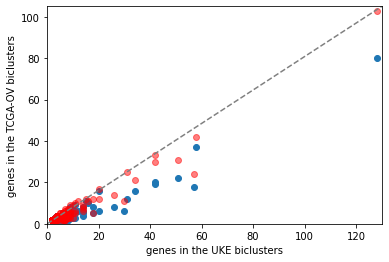

In [8]:
from unpast.utils.method import cluster_samples, update_bicluster_data
from aux import make_similar_biclusters

exprs_tcga_z = prepare_input_matrix(exprs_tcga, min_n_samples=5,ceiling=3)
tcga_bics, gene_sets_stat = make_similar_biclusters(uke_bics,exprs_tcga_z,seed=analysis_seed)
df = gene_sets_stat.loc[gene_sets_stat["n_genes2"]>=2,:]
sele_tcga_ids = df.index.values 
#sele_tcga_ids = df.loc[df["SNR2"]>1.5,:].index.values 
#tcga_bics = tcga_bics.loc[sele_tcga_ids,:]
#gene_sets_stat = gene_sets_stat.loc[sele_tcga_ids,:]

gene_sets_stat = gene_sets_stat.loc[sele_tcga_ids,:]
tmp = plt.scatter(gene_sets_stat["n_genes"],gene_sets_stat["n_genes2"])
tmp = plt.scatter(gene_sets_stat["n_genes"],gene_sets_stat["n_genes_measured"],color="red",alpha=0.5)
tmp = plt.xlim(0,130)
tmp = plt.ylim(0,105)
tmp = plt.plot([0, 130], [0, 105], ls="--",color="grey")
tmp = plt.xlabel("genes in the UKE biclusters")
tmp = plt.ylabel("genes in the TCGA-OV biclusters")

print(len(sele_tcga_ids), tcga_bics.shape[0])
sele_tcga_ids

In [9]:
tcga_bics["genes_renamed"] = tcga_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b = tcga_bics.copy()
b.sort_values(by = "n_genes",ascending = False).head(30)

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
129,"{6, 7, 8, 15, 16, 17, 25, 27, 28, 29, 30, 31, ...",180,"{ENSG00000211724, ENSG00000211949, ENSG0000024...",80,UP,"{TCGA-24-1104-01, TCGA-09-2044-01, TCGA-24-142...","{4138, 2155, 5763, 7323, 16572, 16079, 16087, ...","{ENSG00000211724, ENSG00000211949, ENSG0000024...",{},1.613471,"{IGKV3D-20, IGHV5-51, IGHV1-2, IGKV3D-15, IGLV..."
70,"{0, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 22, 2...",167,"{ENSG00000133466, ENSG00000137745, ENSG0000024...",37,UP,"{TCGA-13-1485-01, TCGA-24-1422-01, TCGA-29-169...","{8194, 4743, 3469, 16397, 6416, 9756, 16924, 1...","{ENSG00000133466, ENSG00000137745, ENSG0000024...",{},1.740507,"{GALNT5, LINC00922, SRPX2, VCAN, LRRC15, CCL11..."
69,"{0, 3, 5, 8, 10, 12, 15, 20, 22, 23, 27, 31, 3...",165,"{ENSG00000196335, ENSG00000169548, ENSG0000010...",22,DOWN,"{TCGA-24-1104-01, TCGA-13-1485-01, TCGA-09-204...","{16656, 15769, 12954, 282, 16027, 11036, 16925...",{},"{ENSG00000196335, ENSG00000169548, ENSG0000010...",1.680792,"{GABRA3, TCF24, MROH2A, TKTL1, LINC00649, WDR7..."
40,"{1, 2, 7, 9, 13, 14, 16, 18, 25, 32, 34, 38, 4...",103,"{ENSG00000139200, ENSG00000092054, ENSG0000020...",20,UP,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-20-168...","{11393, 17027, 3465, 15636, 1944, 14371, 9765,...","{ENSG00000139200, ENSG00000092054, ENSG0000020...",{},1.595897,"{PIANP, TSPAN19, UGT3A1, ADGRV1, DPYSL5, PCDH8..."
27,"{0, 1, 2, 3, 9, 14, 18, 21, 25, 32, 37, 38, 39...",173,"{ENSG00000012504, ENSG00000103460, ENSG0000018...",19,UP,"{TCGA-24-1104-01, TCGA-36-1575-01, TCGA-13-148...","{14217, 4883, 6420, 13590, 291, 7860, 63, 1632...","{ENSG00000012504, ENSG00000103460, ENSG0000018...",{},1.825415,"{CASR, TOX3, DCAF8L2, ARX, PROK1, RGS7, AMHR2,..."
57,"{1, 7, 9, 13, 14, 16, 18, 19, 21, 25, 29, 30, ...",161,"{ENSG00000186439, ENSG00000173157, ENSG0000023...",18,UP,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-20-168...","{16823, 13188, 12869, 12584, 13866, 15626, 156...","{ENSG00000186439, ENSG00000173157, ENSG0000023...",{},1.56853,"{LINC01249, OR5BH1P, VCX, LINC01611, OR56A3, A..."
63,"{0, 6, 7, 8, 10, 11, 12, 16, 17, 19, 20, 22, 2...",148,"{ENSG00000083782, ENSG00000170044, ENSG0000018...",16,UP,"{TCGA-13-1485-01, TCGA-24-1422-01, TCGA-29-169...","{12451, 15300, 1671, 10890, 1419, 12602, 3469,...","{ENSG00000083782, ENSG00000170044, ENSG0000026...",{},1.719146,"{KCNA1, CYP26A1, GALNT5, LINC00922, SERPINB7, ..."
85,"{0, 1, 11, 14, 20, 21, 32, 33, 34, 37, 38, 44,...",102,"{ENSG00000164287, ENSG00000205835, ENSG0000013...",16,UP,"{TCGA-13-1485-01, TCGA-20-1684-01, TCGA-04-151...","{12257, 13315, 11560, 15340, 15597, 14607, 103...","{ENSG00000164287, ENSG00000205835, ENSG0000013...",{},1.596508,"{GMNC, FRMPD2, MS4A8, C1orf87, STOML3, ANKRD66..."
122,"{0, 1, 2, 3, 7, 9, 13, 14, 16, 18, 21, 25, 27,...",147,"{ENSG00000092051, ENSG00000092054, ENSG0000014...",12,UP,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-13-148...","{17027, 13092, 5926, 4231, 7112, 10675, 14067,...","{ENSG00000092051, ENSG00000141431, ENSG0000009...",{},1.466208,"{JPH4, HTR1E, SULT1C4, MYH7, GDF10, PHF21B, EP..."
155,"{0, 1, 4, 5, 9, 11, 14, 21, 25, 32, 34, 37, 38...",135,"{ENSG00000203963, ENSG00000176381, ENSG0000012...",11,UP,"{TCGA-13-1485-01, TCGA-20-1684-01, TCGA-04-151...","{4897, 9448, 11849, 13385, 13067, 4846, 11634,...","{ENSG00000203963, ENSG00000176381, ENSG0000016...",{},1.443565,"{LRRC74B, C1orf141, WDR49, FAM81B, ADGB, PRR18..."


In [10]:
b= tcga_bics.copy()
g ="PTH2R" #
b[b["genes_renamed"].apply(lambda x: g in x)] 

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
84,"{0, 3, 5, 8, 10, 12, 15, 22, 23, 33, 36, 37, 4...",164,"{ENSG00000205359, ENSG00000144407, ENSG0000025...",4,DOWN,"{TCGA-24-1104-01, TCGA-13-1485-01, TCGA-09-204...","{7512, 15306, 14554, 16539}",{},"{ENSG00000205359, ENSG00000144407, ENSG0000022...",1.582074,"{LINC00491, LINC01456, PTH2R, SLCO6A1}"


In [11]:
g =  "ADIPOQ"#
b[b["genes_renamed"].apply(lambda x: g in x)]

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
130,"{6, 8, 11, 12, 17, 20, 24, 27, 29, 31, 32, 33,...",89,"{ENSG00000176194, ENSG00000187288, ENSG0000018...",6,UP,"{TCGA-29-1695-01, TCGA-13-1404-01, TCGA-24-203...","{3491, 16388, 10931, 13304, 11833, 12414}","{ENSG00000176194, ENSG00000187288, ENSG0000018...",{},2.024598,"{RERGL, ADIPOQ, CIDEC, LINC01096, CIDEA, FABP4}"


In [12]:
len(b.loc[70,"genes"])

37

In [13]:
#b.loc[70,"genes_renamed"]

In [14]:
g =  "EDN3"#
b[b["genes_renamed"].apply(lambda x: g in x)]

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
27,"{0, 1, 2, 3, 9, 14, 18, 21, 25, 32, 37, 38, 39...",173,"{ENSG00000012504, ENSG00000103460, ENSG0000018...",19,UP,"{TCGA-24-1104-01, TCGA-36-1575-01, TCGA-13-148...","{14217, 4883, 6420, 13590, 291, 7860, 63, 1632...","{ENSG00000012504, ENSG00000103460, ENSG0000018...",{},1.825415,"{CASR, TOX3, DCAF8L2, ARX, PROK1, RGS7, AMHR2,..."


In [15]:
g =  "SPINK5"#
b[b["genes_renamed"].apply(lambda x: g in x)]

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
69,"{0, 3, 5, 8, 10, 12, 15, 20, 22, 23, 27, 31, 3...",165,"{ENSG00000196335, ENSG00000169548, ENSG0000010...",22,DOWN,"{TCGA-24-1104-01, TCGA-13-1485-01, TCGA-09-204...","{16656, 15769, 12954, 282, 16027, 11036, 16925...",{},"{ENSG00000196335, ENSG00000169548, ENSG0000010...",1.680792,"{GABRA3, TCF24, MROH2A, TKTL1, LINC00649, WDR7..."


In [16]:
g =  "SOX17"#
b[b["genes_renamed"].apply(lambda x: g in x)]

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed


# DASL

In [17]:
exprs_dasl = pd.read_csv("../data/DASL_377.exprs.tsv.gz",sep="\t",index_col=0)
print(exprs_dasl.shape)
exprs_dasl_z = prepare_input_matrix(exprs_dasl, min_n_samples=5,ceiling=3)
exprs_dasl.head(2)

(19369, 377)


,X5800701006_B,X5800701006_C,X5800701006_D,X5800701006_E,X5800701006_F,X5800701006_G,X5800701006_I,X5800701006_J,X5800701006_K,X5800701006_L,...,X6828280034_C,X6828280034_F,X6828280034_H,X6828280034_I,X6828280034_J,X6828280034_K,X6828280034_L,X6828301015_B,X6828301015_C,X6828301015_D
ENSG00000000003,9.909752,9.525017,9.389951,8.906697,8.872511,9.435739,8.682605,8.263090,10.024749,7.500624,...,8.821913,9.981615,8.306561,9.164281,7.774171,8.969784,10.373839,9.417089,9.138731,8.597400
ENSG00000000005,5.796944,6.934209,6.029834,8.056683,5.848083,10.293842,12.859131,5.729206,7.629308,5.864953,...,7.105938,6.985320,7.148474,7.285059,7.248570,8.255288,9.003298,7.328400,7.132316,8.051942


64


array([  3,   7,   8,   9,  10,  13,  20,  22,  23,  26,  27,  31,  34,
        35,  40,  41,  42,  43,  47,  54,  57,  59,  60,  62,  63,  67,
        69,  70,  72,  81,  82,  83,  84,  85,  90,  95,  98,  99, 100,
       101, 103, 106, 107, 109, 117, 120, 122, 126, 129, 130, 139, 144,
       146, 147, 148, 152, 155, 156, 157, 158, 163, 167, 168, 173])

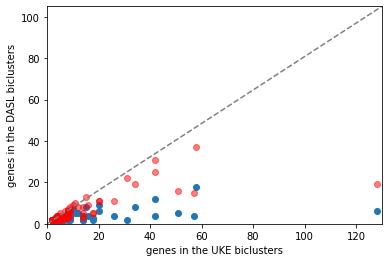

In [18]:
dasl_bics, gene_sets_stat = make_similar_biclusters(uke_bics, 
                                                    exprs_dasl_z,
                                                    seed=analysis_seed)
df = gene_sets_stat.loc[gene_sets_stat["n_genes2"]>=2,:]
sele_ids_dasl = df.index.values 
#sele_ids_dasl= df.loc[df["SNR2"]>1.5,:].index.values 
gene_sets_stat = gene_sets_stat.loc[sele_ids_dasl,:]
#dasl_bics = dasl_bics.loc[sele_ids_dasl,:]
#gene_sets_stat = gene_sets_stat.loc[sele_ids_dasl,:]
tmp = plt.scatter(gene_sets_stat["n_genes"],gene_sets_stat["n_genes2"])
tmp = plt.scatter(gene_sets_stat["n_genes"],gene_sets_stat["n_genes_measured"],color="red",alpha=0.5)
tmp = plt.xlim(0,130)
tmp = plt.ylim(0,105)
tmp = plt.plot([0, 130], [0, 105], ls="--",color="grey")
tmp = plt.xlabel("genes in the UKE biclusters")
tmp = plt.ylabel("genes in the DASL biclusters")
print(len(sele_ids_dasl))
sele_ids_dasl

In [19]:
# DASL and TCGA
print(sorted(set(sele_ids_dasl).intersection(sele_tcga_ids)))
len(set(sele_ids_dasl).intersection(sele_tcga_ids))

[3, 7, 8, 9, 10, 13, 20, 22, 23, 26, 27, 31, 34, 35, 40, 41, 42, 43, 47, 54, 57, 59, 60, 62, 63, 67, 69, 70, 72, 81, 82, 83, 84, 85, 90, 95, 98, 99, 100, 101, 103, 106, 107, 109, 117, 120, 122, 126, 129, 130, 139, 144, 146, 147, 148, 152, 155, 156, 157, 158, 163, 167, 168, 173]


64

In [20]:
# only DASL
print(sorted(set(sele_ids_dasl).difference(sele_tcga_ids)))
len(set(sele_ids_dasl).difference(sele_tcga_ids))

[]


0

In [21]:
# Only TCGA
print(sorted(set(sele_tcga_ids).difference(sele_ids_dasl)))
len(set(sele_tcga_ids).difference(sele_ids_dasl))

[4, 15, 18, 21, 25, 28, 33, 39, 46, 48, 49, 51, 56, 71, 73, 74, 75, 77, 80, 86, 89, 91, 104, 105, 113, 114, 115, 116, 121, 124, 125, 127, 128, 131, 134, 135, 136, 138, 140, 141, 142, 143, 149, 150, 160, 161, 169, 170, 171, 174, 175, 176]


52

In [22]:
dasl_bics["genes_renamed"] = dasl_bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
b = dasl_bics.copy()
b.sort_values(by = "n_genes",ascending = False).head(30)

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
70,"{1, 2, 3, 5, 6, 7, 10, 12, 14, 16, 18, 19, 22,...",137,"{ENSG00000172061, ENSG00000218336, ENSG0000017...",18,UP,"{X5800701030_J, X5800701030_D, X5800701055_J, ...","{7172, 11365, 16101, 12488, 14155, 8716, 17239...","{ENSG00000172061, ENSG00000218336, ENSG0000017...",{},1.584777,"{C5orf46, ADAM12, GREM1, MMP13, TENM3, NTM, MM..."
27,"{0, 1, 8, 11, 13, 17, 20, 21, 26, 28, 31, 32, ...",142,"{ENSG00000189292, ENSG00000036828, ENSG0000017...",12,UP,"{X5800701006_K, X5800701030_J, X5800710007_J, ...","{514, 13734, 8552, 7930, 14701, 17966, 2159, 5...","{ENSG00000189292, ENSG00000036828, ENSG0000000...",{},1.581703,"{ALKAL2, CASR, ARX, PROK1, NR5A1, NEFH, SPRR2F..."
85,"{257, 132, 260, 8, 268, 144, 17, 146, 20, 21, ...",61,"{ENSG00000164287, ENSG00000133115, ENSG0000017...",9,UP,"{X5800701006_K, X5800701057_D, X5800710016_C, ...","{12384, 13735, 6408, 12105, 15049, 11377, 1448...","{ENSG00000164287, ENSG00000133115, ENSG0000017...",{},1.66575,"{FRMPD2, MS4A8, C1orf87, STOML3, CDHR4, FAM216..."
155,"{0, 257, 132, 134, 8, 9, 265, 268, 141, 269, 1...",75,"{ENSG00000157330, ENSG00000123977, ENSG0000017...",8,UP,"{X5800701006_K, X5800710001_F, X5800744020_J, ...","{5253, 9608, 489, 14728, 5197, 15131, 12958, 5...","{ENSG00000157330, ENSG00000123977, ENSG0000017...",{},1.652505,"{LRRC74B, WDR49, CACNG6, CLXN, DAW1, C20orf85,..."
63,"{2, 3, 5, 6, 7, 10, 12, 14, 16, 18, 22, 25, 29...",126,"{ENSG00000083782, ENSG00000181541, ENSG0000009...",8,UP,"{X5800701030_J, X5800701055_J, X5800744020_L, ...","{1508, 13963, 1966, 1551, 6578, 14167, 792, 4989}","{ENSG00000083782, ENSG00000181541, ENSG0000009...",{},1.417766,"{CYP26A1, SLC35D3, C1QTNF3, COL11A1, CSMD2, MA..."
10,"{0, 1, 8, 11, 13, 17, 20, 21, 26, 28, 31, 32, ...",164,"{ENSG00000189292, ENSG00000036828, ENSG0000012...",7,UP,"{X5800701006_K, X5800701030_J, X5800710007_J, ...","{5632, 514, 8552, 6742, 15383, 7034, 63}","{ENSG00000189292, ENSG00000036828, ENSG0000012...",{},1.519088,"{ALKAL2, CASR, ARX, NR5A1, TSPAN8, AMHR2, STAR}"
20,"{3, 5, 11, 14, 15, 28, 29, 35, 36, 42, 46, 47,...",102,"{ENSG00000169035, ENSG00000125618, ENSG0000011...",6,DOWN,"{X5800744040_D, X5800744007_I, X5800701030_J, ...","{13923, 18339, 5420, 3925, 2427, 11839}",{},"{ENSG00000169035, ENSG00000125618, ENSG0000011...",1.185527,"{RHEX, PAX8, KLK7, MUC16, CCN6, WFDC2}"
83,"{130, 132, 8, 137, 138, 11, 14, 272, 17, 147, ...",57,"{ENSG00000241388, ENSG00000171564, ENSG0000027...",6,UP,"{X5800701006_K, X5800701057_D, X5800701055_F, ...","{2247, 17864, 18608, 18035, 12378, 12380}","{ENSG00000241388, ENSG00000171564, ENSG0000027...",{},1.532817,"{FGB, FGA, HNF1B, GBA3, CCDC198, HNF1A-AS1}"
129,"{5, 6, 7, 13, 18, 19, 24, 26, 28, 29, 30, 33, ...",105,"{ENSG00000116748, ENSG00000143297, ENSG0000013...",6,UP,"{X5800710052_J, X5800701030_J, X5800701055_J, ...","{4423, 2953, 17839, 10493, 6239, 7967}","{ENSG00000116748, ENSG00000143297, ENSG0000013...",{},1.318776,"{CD79A, FCRL1, FCRL5, FCRLA, AMPD1, TNFRSF13B}"
99,"{1, 3, 5, 6, 7, 10, 11, 14, 16, 19, 22, 27, 29...",161,"{ENSG00000165124, ENSG00000164176, ENSG0000010...",5,UP,"{X5800701030_J, X5800701055_J, X5800710007_J, ...","{263, 10953, 5617, 2556, 10719}","{ENSG00000165124, ENSG00000164176, ENSG0000010...",{},1.299464,"{SRPX2, OMD, SVEP1, EDIL3, FMO1}"


In [23]:
g =  "PAX8"#
b[b["genes_renamed"].apply(lambda x: g in x)]

,sample_indexes,n_samples,genes,n_genes,direction,samples,gene_indexes,genes_up,genes_down,SNR,genes_renamed
20,"{3, 5, 11, 14, 15, 28, 29, 35, 36, 42, 46, 47,...",102,"{ENSG00000169035, ENSG00000125618, ENSG0000011...",6,DOWN,"{X5800744040_D, X5800744007_I, X5800701030_J, ...","{13923, 18339, 5420, 3925, 2427, 11839}",{},"{ENSG00000169035, ENSG00000125618, ENSG0000011...",1.185527,"{RHEX, PAX8, KLK7, MUC16, CCN6, WFDC2}"


# Find biclusters best matching known molecular subtypes

In [24]:
def make_known_groups(annot, target_col="genefu_z", verbose=False):
    samples = set(annot.index.values)
    if verbose:
        print("Total samples:", len(samples), file=sys.stdout)
    annot = annot.loc[list(samples), :]
    groups = set(annot.loc[:, target_col].values)

    known_groups = {}
    for group in groups:
        if group == group:
            group_samples = set(annot.loc[annot[target_col] == group, :].index.values)
            group_samples = group_samples.intersection(samples)
            if len(group_samples) > int(len(samples) / 2):
                print("take complement of ", group, file=sys.stderr)
                group_samples = samples.difference(group_samples)
            known_groups[
                group
            ] = group_samples  # {"set":group_samples,"complement": samples.difference(group_samples)}
            if verbose:
                print(
                    group,
                    round(len(group_samples) / len(samples), 2),
                    len(group_samples),
                    len(samples.difference(group_samples)),
                )
    return known_groups

In [25]:
subt_dict = {"DIF_consensus":'differentiated',
            "MES_consensus": 'mesenchymal',
            "IMR_consensus":'immunoreactive',
            "PRO_consensus": 'proliferative',
            "NA":"NA"}
subt_dict.update({'DIF': 'differentiated',
 'MES': 'mesenchymal',
 'IMR': 'immunoreactive',
 'PRO': 'proliferative',
 'NA': 'NA'}) 
color_dict = {"consensusOV":{
    "MES_consensus":"orange",
    "PRO_consensus":"lime",
    "IMR_consensus": "magenta",
    "DIF_consensus":"cyan"
    },
    "subtype":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Verhaak":{"MES":"orange", "mesenchymal":"orange",
    "PRO":"lime", 'proliferative':'lime',
    "IMR": "magenta", 'immunoreactive':'magenta',
    "DIF":"cyan",'differentiated':"cyan"
    },
    "Bentink":{
    'Angiogenic':'violet',
    'nonAngiogenic':'gold'},
}

In [26]:
pm = "ARI"

### UKE

In [27]:
annot_uke = annot
exprs_uke_z = prepare_input_matrix(exprs.loc[:,annot_uke.index], min_n_samples=5,ceiling=3)
subt_uke = pd.read_csv("../data/OVcancer_subtypes/UKE181_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_uke["subtype"] = subt_uke["consensusOV"].apply(lambda x: subt_dict[x])
subt_uke.head(2)

,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
sample_id,,,,,,
T0063,DIF_consensus,MES,C4_mescL,C1,nonAngiogenic,differentiated
T0096,DIF_consensus,DIF,C3_profL,C2,Angiogenic,differentiated


In [28]:
known_groups_uke = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_uke[subt] = make_known_groups(subt_uke, target_col = subt)
known_groups_uke.keys()

take complement of  nonAngiogenic


dict_keys(['subtype', 'Verhaak', 'Konecny', 'Helland', 'Bentink'])

In [29]:
from unpast.utils.eval import calculate_perfromance
performances, best_matches_uke = calculate_perfromance(uke_bics,
                                                   known_groups_uke,
                                                   set(subt_uke.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.343156
Verhaak    0.232724
Konecny    0.239672
Helland    0.322454
Bentink    0.553832
dtype: float64

In [30]:
best_matches_uke

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
immunoreactive,81,0.262525,0.276243,0.000134,True,"{T6731, T4720, T6733, T6284, T1637, T6621, T20...",47,subtype
differentiated,157,0.345797,0.265193,0.000133,True,"{T3195, T4817, T6730, T5741, T1413, T6460, T66...",62,subtype
proliferative,40,0.482436,0.149171,0.000162,True,"{T6284, T6696, T6670, T1413, T6662, T6885, T69...",32,subtype
mesenchymal,105,0.345732,0.309392,0.00016,True,"{T6731, T4720, T1637, T0342, T6680, T6549, T66...",83,subtype
MES,105,0.216029,0.292818,0.000088,True,"{T6731, T4720, T1637, T0342, T6680, T6549, T66...",83,Verhaak
DIF,141,0.195438,0.254144,0.000538,True,"{T3195, T4720, T2645, T6730, T5741, T6621, T20...",60,Verhaak
PRO,40,0.551663,0.154696,0.000031,True,"{T6284, T6696, T6670, T1413, T6662, T6885, T69...",32,Verhaak
IMR,172,0.115495,0.298343,0.001424,True,"{T3195, T6731, T1637, T5741, T6798, T0342, T67...",81,Verhaak
C1_immL,81,0.309484,0.303867,0.000318,True,"{T6731, T4720, T6733, T6284, T1637, T6621, T20...",47,Konecny
C3_profL,146,0.028724,0.21547,0.001304,False,"{T6731, T4720, T4817, T6798, T0342, T6759, T67...",79,Konecny


In [31]:
from unpast.utils.figs import draw_heatmap2

In [32]:
exprs_uke_z_rn = rename_genes_in_exprs(exprs_uke_z)

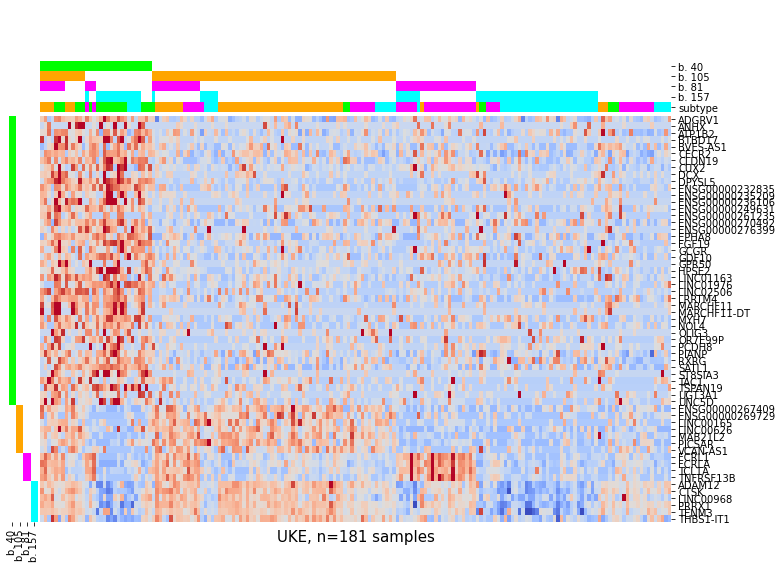

In [33]:
#cl = "Verhaak"
cl = "subtype"
#cl= "Bentink"

best_matches = best_matches_uke
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))
bics = rename_genes_in_biclusters(uke_bics.copy())
bics["genes"] = bics["genes"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
bics["genes_up"] = bics["genes_up"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))
bics["genes_down"] = bics["genes_down"].apply(lambda genes: set([rename_gene(x, keep_not_mapped=True) for x in genes]))

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])
    
fig, samples, colors = draw_heatmap2(exprs_uke_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_uke.loc[:,["subtype"]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%annot_uke.shape[0], fontsize=15)

### DASL

In [34]:
annot_dasl = pd.read_csv("../data/DASL.annotation_Kommoss.tsv.gz",sep ="\t",index_col=0)
subt_dasl = pd.read_csv("../data/OVcancer_subtypes//DASL_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_dasl["subtype"] = subt_dasl["consensusOV"].apply(lambda x: subt_dict[x])
known_groups_dasl = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_dasl[subt] = make_known_groups(subt_dasl, target_col = subt)
subt_dasl.head(2)

take complement of  nonAngiogenic


,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
sample_id,,,,,,
X5800701006_B,DIF_consensus,DIF,C2_diffL,C4,nonAngiogenic,differentiated
X5800701006_C,PRO_consensus,PRO,C3_profL,C5,nonAngiogenic,proliferative


In [35]:
performances, best_matches_dasl = calculate_perfromance(dasl_bics,
                                                   known_groups_dasl,
                                                   set(subt_dasl.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.254004
Verhaak    0.200750
Konecny    0.260554
Helland    0.333950
Bentink    0.503022
dtype: float64

In [36]:
best_matches_dasl

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
immunoreactive,129,0.148846,0.297082,0.000086,True,"{X5800710052_J, X5800701030_J, X5800701055_J, ...",105,subtype
differentiated,155,0.185856,0.297082,0.000122,True,"{X5800701006_K, X5800710001_F, X5800744020_J, ...",75,subtype
proliferative,40,0.474847,0.177719,0.000101,True,"{X5800701056_L, X5800710029_L, X5800701019_G, ...",80,subtype
mesenchymal,63,0.307652,0.228117,0.000123,True,"{X5800701030_J, X5800701055_J, X5800744020_L, ...",126,subtype
MES,63,0.221162,0.183024,0.000124,True,"{X5800701030_J, X5800701055_J, X5800744020_L, ...",126,Verhaak
DIF,147,0.104051,0.466844,0.000097,False,"{X5800701006_K, X5800744007_I, X5800701030_J, ...",166,Verhaak
PRO,40,0.495757,0.164456,0.000041,True,"{X5800701056_L, X5800710029_L, X5800701019_G, ...",80,Verhaak
IMR,81,0.162467,0.185676,0.0001,True,"{X5800710052_J, X5800701030_J, X5800701055_J, ...",107,Verhaak
C3_profL,40,0.187435,0.201592,0.000068,True,"{X5800701056_L, X5800710029_L, X5800701019_G, ...",80,Konecny
C4_mescL,63,0.395926,0.236074,0.000095,True,"{X5800701030_J, X5800701055_J, X5800744020_L, ...",126,Konecny


In [37]:
exprs_dasl_z_rn = rename_genes_in_exprs(exprs_dasl_z)

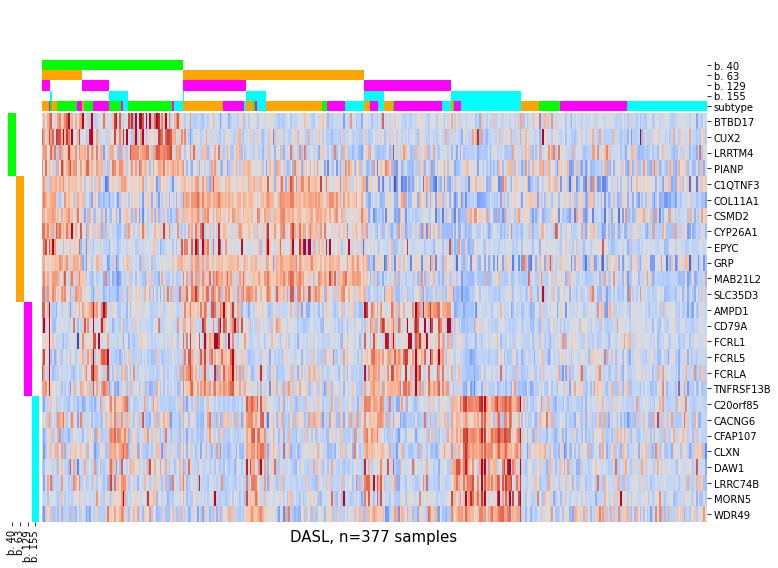

In [38]:
#cl = "Verhaak"
cl = "subtype"
#cl = "Bentink"

best_matches = best_matches_dasl
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))

bics = rename_genes_in_biclusters(dasl_bics.copy())

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])


fig, samples, colors = draw_heatmap2(exprs_dasl_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_dasl.loc[:,[cl]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%annot_dasl.shape[0], fontsize=15)

In [39]:
bics.loc[bm_ids,["genes","SNR"]]

,genes,SNR
40,"{LRRTM4, CUX2, BTBD17, PIANP}",1.107424
63,"{CYP26A1, SLC35D3, C1QTNF3, COL11A1, CSMD2, MA...",1.417766
129,"{CD79A, FCRL1, FCRL5, FCRLA, AMPD1, TNFRSF13B}",1.318776
155,"{LRRC74B, WDR49, CACNG6, CLXN, DAW1, C20orf85,...",1.652505


### TCGA-OV

In [40]:
subt_tcga = pd.read_csv("../data/OVcancer_subtypes/TCGA_OVconsensus_subtypes.tsv",sep="\t",index_col=0)
subt_tcga["subtype"] = subt_tcga["consensusOV"].apply(lambda x: subt_dict[x])
subt_tcga.index = [ x.replace(".","-")  for x in subt_tcga.index]
known_groups_tcga = {}
for subt in ["subtype","Verhaak","Konecny","Helland","Bentink"]:
    known_groups_tcga[subt] = make_known_groups(subt_tcga, target_col = subt)
subt_tcga.head(2)

take complement of  nonAngiogenic


,consensusOV,Verhaak,Konecny,Helland,Bentink,subtype
TCGA-13-1485-01,MES_consensus,MES,C3_profL,C1,Angiogenic,mesenchymal
TCGA-25-1315-01,PRO_consensus,PRO,C3_profL,C5,nonAngiogenic,proliferative


In [41]:
performances, best_matches_tcga = calculate_perfromance(tcga_bics,
                                                   known_groups_tcga,
                                                   set(subt_tcga.index.values),
                                                   performance_measure=pm
                                                  )
performances

subtype    0.311318
Verhaak    0.283202
Konecny    0.216633
Helland    0.361247
Bentink    0.743164
dtype: float64

In [42]:
best_matches_tcga

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
mesenchymal,63,0.474771,0.234742,0.000131,True,"{TCGA-13-1485-01, TCGA-24-1422-01, TCGA-29-169...",148,subtype
immunoreactive,81,0.157694,0.29108,0.000199,True,"{TCGA-24-1104-01, TCGA-09-2044-01, TCGA-13-091...",144,subtype
proliferative,40,0.57453,0.204225,0.000127,True,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-20-168...",103,subtype
differentiated,85,0.135704,0.269953,0.000336,True,"{TCGA-13-1485-01, TCGA-20-1684-01, TCGA-04-151...",102,subtype
MES,63,0.420512,0.220657,0.000144,True,"{TCGA-13-1485-01, TCGA-24-1422-01, TCGA-29-169...",148,Verhaak
DIF,140,0.09945,0.314554,0.000223,True,"{TCGA-24-1104-01, TCGA-13-1485-01, TCGA-24-142...",163,Verhaak
PRO,40,0.6087,0.20892,0.000144,True,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-20-168...",103,Verhaak
IMR,81,0.124911,0.255869,0.000233,True,"{TCGA-24-1104-01, TCGA-09-2044-01, TCGA-13-091...",144,Verhaak
C3_profL,40,0.232724,0.190141,0.00012,True,"{TCGA-36-1575-01, TCGA-OY-A56Q-01, TCGA-20-168...",103,Konecny
C4_mescL,63,0.404023,0.241784,0.000171,True,"{TCGA-13-1485-01, TCGA-24-1422-01, TCGA-29-169...",148,Konecny


In [43]:
exprs_tcga_z_rn = rename_genes_in_exprs(exprs_tcga_z)

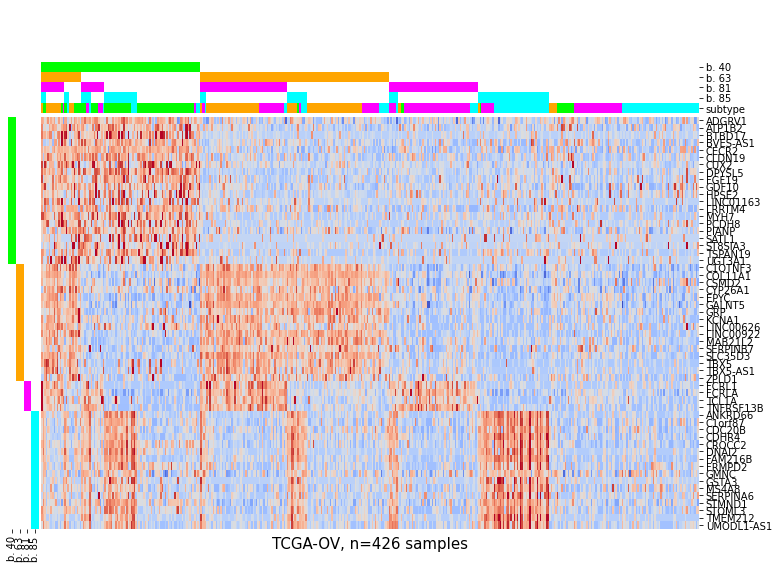

In [44]:
#cl = "Verhaak"
cl = "subtype"
#cl = "Bentink"

best_matches = best_matches_tcga
bm_ids = sorted(set(best_matches.loc[best_matches["classification"]==cl,"bm_id"].values))
bics = rename_genes_in_biclusters(tcga_bics.copy())

bm = best_matches.loc[best_matches["classification"]==cl,:]
bm_ids = []
bm_colors = []

subts = reversed(sorted(best_matches.loc[best_matches["classification"]==cl,['bm_id']].drop_duplicates().index))
for subt in subts:
    bm_ids.append(bm.loc[subt,"bm_id"])
    # color best matching biclusters the same
    bm_colors.append(color_dict[cl][subt])


fig, samples, colors = draw_heatmap2(exprs_tcga_z_rn.copy(),
                    bics.loc[bm_ids,:],
                    annot = subt_tcga.loc[:,[cl]],
                    color_dict= color_dict,
                  bicluster_colors=bm_colors,
                  figsize = (12,8), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(0.02/12*6, 0.02),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=15)

In [45]:
bics.loc[bm_ids,["genes","SNR"]]

,genes,SNR
40,"{PIANP, TSPAN19, UGT3A1, ADGRV1, DPYSL5, PCDH8...",1.595897
63,"{KCNA1, CYP26A1, GALNT5, LINC00922, SERPINB7, ...",1.719146
81,"{TCL1A, FCRLA, FCRL1, TNFRSF13B}",1.433103
85,"{GMNC, FRMPD2, MS4A8, C1orf87, STOML3, ANKRD66...",1.596508


# Conclusion
* bicluster **40** is the best match for **proliferative** in all three cohorts 
* bicluster **81** is the best match for **immunoreacive** in the UKE and TCGA-OV, in the DASL 
* bicluster **63** best matching **mesenchymal** in the DASL and TCGA-OV, in the UKE its best matching bic.105
* **differentiated** betst matches with bics. 157, 155 and 85 in the UKE, DASL and TCGA respectively

# Find biclusters dissimilar from known four subtypes

In [46]:
from unpast.utils.eval import  evaluate_overlaps_ARI, apply_bh
max_ARI = 0.25
pval = 0.05

In [47]:
pvals_uke, is_enriched_uke, ari_uke = evaluate_overlaps_ARI(uke_bics, 
                                                            known_groups_uke["subtype"], 
                                                            set(annot_uke.index))
adj_pvals_uke  = apply_bh(pvals_uke)
#adj_pvals_uke["min_adj_pval"] = adj_pvals_uke.min(axis=1)
ari_uke["max_ARI"] = ari_uke[adj_pvals_uke<pval].max(axis=1)
ari_uke["max_ARI"] = ari_uke["max_ARI"].fillna(-1)
uke_ids = set(ari_uke.loc[ari_uke["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(uke_ids ))

167


In [48]:
pvals_dasl, is_enriched_dasl, ari_dasl = evaluate_overlaps_ARI(dasl_bics, 
                                                            known_groups_dasl["subtype"], 
                                                            set(annot_dasl.index))
adj_pvals_dasl  = apply_bh(pvals_dasl)
#adj_pvals_dasl["min_adj_pval"] = adj_pvals_dasl.min(axis=1)
ari_dasl["max_ARI"] = ari_dasl[adj_pvals_dasl<pval].max(axis=1)
dasl_ids = set(ari_dasl.loc[ari_dasl["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(dasl_ids ))

49


In [49]:
pvals_tcga, is_enriched_tcga, ari_tcga = evaluate_overlaps_ARI(tcga_bics, 
                                                            known_groups_tcga["subtype"], 
                                                            set(subt_tcga.index))
adj_pvals_tcga  = apply_bh(pvals_tcga)
#adj_pvals_tcga["min_adj_pval"] = adj_pvals_tcga.min(axis=1)
ari_tcga["max_ARI"] = ari_tcga[adj_pvals_tcga<pval].max(axis=1)
tcga_ids = set(ari_tcga.loc[ari_tcga["max_ARI"]<max_ARI,:].index.values)#.sort_values(by="max_ARI",ascending= False)
print(len(tcga_ids ))

78


In [50]:
# TCGA
print("same with TCGA:",len(uke_ids.intersection(tcga_ids)))
uke_bics.loc[uke_ids.intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False)

same with TCGA: 75


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
129,1.575306,128,86,"{ENSG00000211724, ENSG00000211949, ENSG0000025...","{T6731, T4720, T1637, T5741, T0342, T6662, T67...","{ENSG00000211724, ENSG00000211949, ENSG0000025...",{},"{11777, 14342, 15376, 6161, 11794, 12816, 3093...","{3, 4, 5, 6, 12, 13, 15, 16, 18, 28, 29, 38, 4...",UP,31,seed=107473_103 seed=107473_159 seed=107473_84...,"{IGKV3D-20, IGHV5-51, IGHV1-2, IGKV3D-15, IGLV..."
57,1.729963,57,54,"{ENSG00000261235, ENSG00000251350, ENSG0000025...","{T6733, T6284, T6696, T6313, T6662, T0096, T68...","{ENSG00000261235, ENSG00000251350, ENSG0000025...",{},"{10628, 1927, 8584, 6409, 22540, 9230, 22672, ...","{1, 129, 131, 132, 133, 6, 13, 14, 15, 16, 17,...",UP,15,seed=107473_46 seed=116739_59 seed=146316_30 s...,"{ENSG00000261235, LINC01249, TYRP1, ENSG000002..."
69,1.693356,51,83,"{ENSG00000150201, ENSG00000196335, ENSG0000016...","{T6662, T6759, T6995, T6549, T5180, T6343, T17...","{ENSG00000150201, ENSG00000196335, ENSG0000016...",{},"{9984, 14093, 9230, 18062, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{GABRA3, TCF24, F11-AS1, BNIPL, MROH2A, TCL6, ..."
27,1.897329,42,25,"{ENSG00000189292, ENSG00000272620, ENSG0000001...","{T4817, T1413, T6460, T6796, T4032, T0315, T33...","{ENSG00000189292, ENSG00000272620, ENSG0000001...",{},"{7680, 20865, 19074, 22158, 6927, 3598, 13714,...","{0, 4, 6, 134, 11, 16, 17, 145, 20, 150, 153, ...",UP,10,seed=107473_11 seed=116739_29 seed=146316_31 s...,"{ADRB3, CASR, FAM230I, ENSG00000255394, PCARE,..."
103,1.619019,26,36,"{ENSG00000158639, ENSG00000282815, ENSG0000016...","{T6731, T6284, T5741, T6662, T0315, T6713, T67...","{ENSG00000158639, ENSG00000282815, ENSG0000016...",{},"{8194, 9479, 8341, 16666, 5149, 17821, 14238, ...","{129, 4, 133, 6, 137, 13, 14, 15, 16, 17, 146,...",UP,10,seed=107473_139 seed=116739_44 seed=146316_51 ...,"{CNTNAP4, PLA2G3, CFHR4, MAGEC2, GAGE2A, ENSG0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1.554258,2,79,"{ENSG00000158488, ENSG00000179639}","{T6731, T4720, T4817, T6798, T0342, T6759, T67...","{ENSG00000158488, ENSG00000179639}",{},"{18109, 18271}","{0, 2, 3, 5, 7, 8, 13, 14, 15, 18, 19, 27, 29,...",UP,8,seed=107473_128 seed=116739_148 seed=146316_15...,"{CD1E, FCER1A}"
31,1.860618,2,41,"{ENSG00000151360, ENSG00000118004}","{T2645, T4817, T6670, T1413, T6460, T6796, T03...","{ENSG00000151360, ENSG00000118004}",{},"{23308, 15599}","{0, 2, 4, 133, 6, 7, 134, 11, 13, 16, 17, 145,...",UP,9,seed=107473_30 seed=116739_159 seed=146316_16 ...,"{COLEC11, ALLC}"
169,1.523294,2,68,"{ENSG00000204969, ENSG00000204970}","{T6731, T4720, T4817, T6932, T1637, T5741, T69...",{},"{ENSG00000204969, ENSG00000204970}","{11515, 87}","{1, 130, 132, 5, 134, 137, 10, 138, 12, 13, 13...",DOWN,2,seed=107473_148 seed=26225_195,"{PCDHA1, PCDHA2}"


In [51]:
# DASL
print("same with DASL:",len(uke_ids.intersection(dasl_ids)))
uke_bics.loc[uke_ids.intersection(dasl_ids),:].sort_values(by = "n_genes",ascending = False)

same with DASL: 46


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
129,1.575306,128,86,"{ENSG00000211724, ENSG00000211949, ENSG0000025...","{T6731, T4720, T1637, T5741, T0342, T6662, T67...","{ENSG00000211724, ENSG00000211949, ENSG0000025...",{},"{11777, 14342, 15376, 6161, 11794, 12816, 3093...","{3, 4, 5, 6, 12, 13, 15, 16, 18, 28, 29, 38, 4...",UP,31,seed=107473_103 seed=107473_159 seed=107473_84...,"{IGKV3D-20, IGHV5-51, IGHV1-2, IGKV3D-15, IGLV..."
57,1.729963,57,54,"{ENSG00000261235, ENSG00000251350, ENSG0000025...","{T6733, T6284, T6696, T6313, T6662, T0096, T68...","{ENSG00000261235, ENSG00000251350, ENSG0000025...",{},"{10628, 1927, 8584, 6409, 22540, 9230, 22672, ...","{1, 129, 131, 132, 133, 6, 13, 14, 15, 16, 17,...",UP,15,seed=107473_46 seed=116739_59 seed=146316_30 s...,"{ENSG00000261235, LINC01249, TYRP1, ENSG000002..."
69,1.693356,51,83,"{ENSG00000150201, ENSG00000196335, ENSG0000016...","{T6662, T6759, T6995, T6549, T5180, T6343, T17...","{ENSG00000150201, ENSG00000196335, ENSG0000016...",{},"{9984, 14093, 9230, 18062, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{GABRA3, TCF24, F11-AS1, BNIPL, MROH2A, TCL6, ..."
27,1.897329,42,25,"{ENSG00000189292, ENSG00000272620, ENSG0000001...","{T4817, T1413, T6460, T6796, T4032, T0315, T33...","{ENSG00000189292, ENSG00000272620, ENSG0000001...",{},"{7680, 20865, 19074, 22158, 6927, 3598, 13714,...","{0, 4, 6, 134, 11, 16, 17, 145, 20, 150, 153, ...",UP,10,seed=107473_11 seed=116739_29 seed=146316_31 s...,"{ADRB3, CASR, FAM230I, ENSG00000255394, PCARE,..."
20,1.948366,20,16,"{ENSG00000083307, ENSG00000169035, ENSG0000017...","{T6731, T3644, T6798, T4979, T6658, T6679, T66...",{},"{ENSG00000083307, ENSG00000169035, ENSG0000017...","{11269, 11909, 19848, 21513, 12426, 18065, 178...","{96, 128, 99, 39, 135, 41, 168, 143, 114, 51, ...",DOWN,10,seed=107473_28 seed=116739_9 seed=146316_7 see...,"{LINC02594, RHEX, CCN6, LINC01320, FAM181A-AS1..."
85,1.659861,20,40,"{ENSG00000164287, ENSG00000133115, ENSG0000017...","{T4817, T6284, T6670, T1413, T6945, T6662, T69...","{ENSG00000164287, ENSG00000133115, ENSG0000017...",{},"{8577, 22666, 8714, 16525, 15379, 17044, 11932...","{0, 2, 131, 6, 7, 137, 11, 139, 141, 16, 145, ...",UP,11,seed=107473_80 seed=116739_70 seed=146316_72 s...,"{GMNC, FRMPD2, CROCC2, LMX1A, STMND1, ENSG0000..."
26,1.921255,18,35,"{ENSG00000253363, ENSG00000265933, ENSG0000019...","{T6731, T6284, T6733, T5741, T6670, T6313, T66...","{ENSG00000253363, ENSG00000265933, ENSG0000019...",{},"{19904, 3, 11688, 3689, 8332, 8303, 6864, 1780...","{129, 131, 4, 133, 6, 14, 15, 17, 153, 28, 31,...",UP,10,seed=107473_20 seed=116739_26 seed=146316_24 s...,"{ENSG00000253363, DSCR8, CNTNAP4, CMKLR2-AS, E..."
47,1.760333,18,58,"{ENSG00000227777, ENSG00000267733, ENSG0000026...","{T6731, T6733, T6284, T6696, T1413, T6313, T66...","{ENSG00000227777, ENSG00000267733, ENSG0000026...",{},"{2755, 23608, 4455, 17801, 9643, 6604, 6476, 1...","{129, 4, 132, 6, 133, 137, 11, 139, 13, 14, 15...",UP,10,seed=107473_26 seed=116739_56 seed=146316_33 s...,"{ENSG00000267733, ENSG00000228697, ENSG0000026..."
155,1.542546,15,66,"{ENSG00000203963, ENSG00000157330, ENSG0000017...","{T2645, T4817, T6284, T6696, T6670, T1413, T69...","{ENSG00000203963, ENSG00000157330, ENSG0000017...",{},"{1605, 15750, 12811, 7083, 21837, 10510, 18295...","{0, 129, 2, 131, 6, 7, 137, 11, 139, 140, 141,...",UP,10,seed=107473_167 seed=116739_197 seed=146316_14...,"{LRRC74B, C1orf141, ENSG00000262890, WDR49, FA..."


In [52]:
# all
print("same with TCGA and DASL:",len(uke_ids.intersection(dasl_ids).intersection(tcga_ids)))
print(uke_bics.loc[uke_ids.intersection(dasl_ids).intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False).index)
uke_bics.loc[uke_ids.intersection(dasl_ids).intersection(tcga_ids),:].sort_values(by = "n_genes",ascending = False)

same with TCGA and DASL: 35
Int64Index([129,  57,  69,  27,  20,  85,  47, 155, 147, 101, 158,  10, 109,
            144,  35, 163,  83, 173,  82,  90,  54, 117,  67,  84,  41, 152,
              7,  23, 107,   9, 120,  42, 139,  31, 146],
           dtype='int64', name='id')


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,genes_renamed
id,,,,,,,,,,,,,
129,1.575306,128,86,"{ENSG00000211724, ENSG00000211949, ENSG0000025...","{T6731, T4720, T1637, T5741, T0342, T6662, T67...","{ENSG00000211724, ENSG00000211949, ENSG0000025...",{},"{11777, 14342, 15376, 6161, 11794, 12816, 3093...","{3, 4, 5, 6, 12, 13, 15, 16, 18, 28, 29, 38, 4...",UP,31,seed=107473_103 seed=107473_159 seed=107473_84...,"{IGKV3D-20, IGHV5-51, IGHV1-2, IGKV3D-15, IGLV..."
57,1.729963,57,54,"{ENSG00000261235, ENSG00000251350, ENSG0000025...","{T6733, T6284, T6696, T6313, T6662, T0096, T68...","{ENSG00000261235, ENSG00000251350, ENSG0000025...",{},"{10628, 1927, 8584, 6409, 22540, 9230, 22672, ...","{1, 129, 131, 132, 133, 6, 13, 14, 15, 16, 17,...",UP,15,seed=107473_46 seed=116739_59 seed=146316_30 s...,"{ENSG00000261235, LINC01249, TYRP1, ENSG000002..."
69,1.693356,51,83,"{ENSG00000150201, ENSG00000196335, ENSG0000016...","{T6662, T6759, T6995, T6549, T5180, T6343, T17...","{ENSG00000150201, ENSG00000196335, ENSG0000016...",{},"{9984, 14093, 9230, 18062, 12688, 2833, 13074,...","{2, 4, 6, 9, 11, 13, 14, 15, 17, 20, 21, 25, 2...",UP,20,seed=107473_70 seed=107473_93 seed=116739_45 s...,"{GABRA3, TCF24, F11-AS1, BNIPL, MROH2A, TCL6, ..."
27,1.897329,42,25,"{ENSG00000189292, ENSG00000272620, ENSG0000001...","{T4817, T1413, T6460, T6796, T4032, T0315, T33...","{ENSG00000189292, ENSG00000272620, ENSG0000001...",{},"{7680, 20865, 19074, 22158, 6927, 3598, 13714,...","{0, 4, 6, 134, 11, 16, 17, 145, 20, 150, 153, ...",UP,10,seed=107473_11 seed=116739_29 seed=146316_31 s...,"{ADRB3, CASR, FAM230I, ENSG00000255394, PCARE,..."
20,1.948366,20,16,"{ENSG00000083307, ENSG00000169035, ENSG0000017...","{T6731, T3644, T6798, T4979, T6658, T6679, T66...",{},"{ENSG00000083307, ENSG00000169035, ENSG0000017...","{11269, 11909, 19848, 21513, 12426, 18065, 178...","{96, 128, 99, 39, 135, 41, 168, 143, 114, 51, ...",DOWN,10,seed=107473_28 seed=116739_9 seed=146316_7 see...,"{LINC02594, RHEX, CCN6, LINC01320, FAM181A-AS1..."
85,1.659861,20,40,"{ENSG00000164287, ENSG00000133115, ENSG0000017...","{T4817, T6284, T6670, T1413, T6945, T6662, T69...","{ENSG00000164287, ENSG00000133115, ENSG0000017...",{},"{8577, 22666, 8714, 16525, 15379, 17044, 11932...","{0, 2, 131, 6, 7, 137, 11, 139, 141, 16, 145, ...",UP,11,seed=107473_80 seed=116739_70 seed=146316_72 s...,"{GMNC, FRMPD2, CROCC2, LMX1A, STMND1, ENSG0000..."
47,1.760333,18,58,"{ENSG00000227777, ENSG00000267733, ENSG0000026...","{T6731, T6733, T6284, T6696, T1413, T6313, T66...","{ENSG00000227777, ENSG00000267733, ENSG0000026...",{},"{2755, 23608, 4455, 17801, 9643, 6604, 6476, 1...","{129, 4, 132, 6, 133, 137, 11, 139, 13, 14, 15...",UP,10,seed=107473_26 seed=116739_56 seed=146316_33 s...,"{ENSG00000267733, ENSG00000228697, ENSG0000026..."
155,1.542546,15,66,"{ENSG00000203963, ENSG00000157330, ENSG0000017...","{T2645, T4817, T6284, T6696, T6670, T1413, T69...","{ENSG00000203963, ENSG00000157330, ENSG0000017...",{},"{1605, 15750, 12811, 7083, 21837, 10510, 18295...","{0, 129, 2, 131, 6, 7, 137, 11, 139, 140, 141,...",UP,10,seed=107473_167 seed=116739_197 seed=146316_14...,"{LRRC74B, C1orf141, ENSG00000262890, WDR49, FA..."
147,1.553793,14,64,"{ENSG00000233338, ENSG00000243531, ENSG0000023...","{T6731, T6284, T6696, T6670, T6662, T6771, T68...",{},"{ENSG00000233338, ENSG00000243531, ENSG0000023...","{16887, 5509, 18280, 15432, 17739, 8697, 2478,...","{128, 129, 130, 3, 132, 133, 10, 138, 141, 142...",DOWN,14,seed=107473_111 seed=107473_177 seed=116739_16...,"{SLC25A3P1, ENSG00000234427, DDX3ILA1, EVA1CP3..."


In [53]:
sele_bics = [129] # # 129,  57,  69,  27,  20,  85,  47
w = 6
fs = 12 # Font size

colors: ['#0173b2']


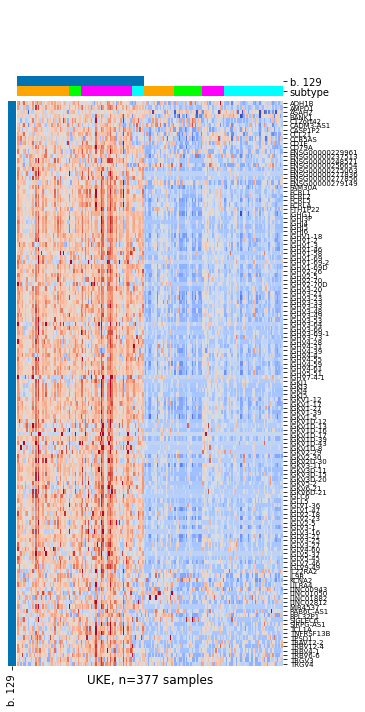

In [54]:
bics = rename_genes_in_biclusters(uke_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
cr = min(0.015*h/10,0.015)
fig, samples, colors = draw_heatmap2(exprs_uke_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_uke.loc[:,["subtype"]],
                    color_dict= color_dict,
                  bicluster_colors="auto",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("UKE, n=%s samples"%subt_dasl.shape[0], fontsize=fs)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

colors: ['#0173b2']


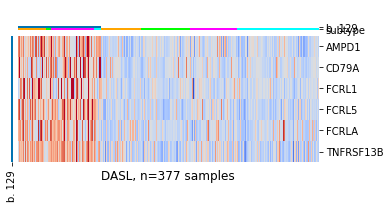

In [55]:
bics = rename_genes_in_biclusters(dasl_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
cr = min(max(0.015,0.05*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_dasl_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_dasl.loc[:,["subtype"]],
                    color_dict= color_dict,
                  bicluster_colors="auto",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("DASL, n=%s samples"%subt_dasl.shape[0], fontsize=fs)

In [56]:
cr

0.015000000000000003

colors: ['#0173b2']


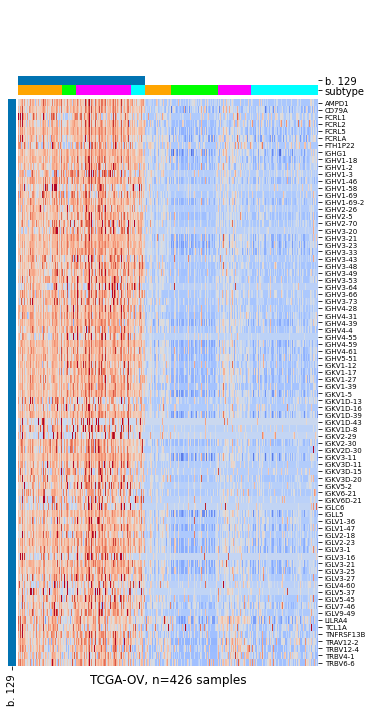

In [57]:
bics = rename_genes_in_biclusters(tcga_bics.copy())
h = min(max(3,bics.loc[sele_bics,"n_genes"].sum()/5),10)
cr = min(max(0.015,0.015*h/10),0.05)
fig, samples, colors = draw_heatmap2(exprs_tcga_z_rn.copy(),
                    bics.loc[sele_bics,:],
                    annot = subt_tcga.loc[:,["subtype"]],
                    color_dict= color_dict,
                  bicluster_colors="auto",
                  figsize = (w,h), 
                  dendrogram_ratio=(0.1,0.1), 
                  colors_ratio=(cr/w*h, cr),
                  bic_prefix = "b. ",
                  no_legend=True,no_cbar=True,
                  col_labels = False,
                  row_labels = True,
                  no_row_colors = False,cluster_rows=False,
                 )
ax = fig.ax_heatmap
tmp = ax.set_xlabel("TCGA-OV, n=%s samples"%subt_tcga.shape[0], fontsize=fs)
if h>=8:
    tmp = ax.set_yticklabels(ax.get_yticklabels(),fontsize=7)

In [58]:
(cr/w*h, cr)

(0.025, 0.015)